In [1]:
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout
from keras import optimizers, regularizers
from datetime import datetime
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import csv
np.random.seed(7)

Using TensorFlow backend.


### Define parameters

### Get Data
1. Coloumn 0 : Temperature 
2. Coloumn 1 : Density
3. Coloumn 2 : P-wave velocity(V_p)    
4. Coloumn 3 : S- wave velocity (V_s)
5. Coloumn 4 : Ratio of V_p and V_s
6. Coloumn 5 : Thermal Energy 
7. Coloumn 6 : Depth(z)
8. Coloumn 7 : x coordinate
9. Coloumn 8 : Stress component xx
10. Coloumn 9 : Stress component xz
11. Coloumn 10 : Stress component zz
    
The data file has no any header and has 11 columns. The X can be first seven columns. We do not need x coordinate (8 column). This column can be ignored. Based on X we want to predict any of the stress components (xx/xz/zz).

In [2]:
no_of_layers = 2
input_layer = 7
output_layer = 1
learning_rate = 0.001
training_epochs = 50
batch_size = 128
keep_prob = 1.0

In [3]:
def get_stress_data():
    filename = "data/stress_data.csv"
    no_of_data = 40000
    raw_data = open(filename, 'rt')
    reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
    data = list(reader)
    data = np.array(data).astype('float')
    X = data[:no_of_data, : input_layer] # [it looks like it is 1 indexed]
    Y = data[:no_of_data, 9] # shear stress [it looks like it is 0 indexed]
    return X, Y

In [4]:
X, Y = get_stress_data()
X, Y = shuffle(X, Y, random_state=0)
Y = Y/1e6
scalex = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
X = scalex.fit_transform(X)
scaley = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
Y = scaley.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
total_len_train = X_train.shape[0]
total_len_test = X_test.shape[0]

FileNotFoundError: [Errno 2] No such file or directory: 'data/stress_data.csv'

In [125]:
print(X_train.shape)
print(X_test.shape)

(32000, 7)
(8000, 7)


### Model setup

In [126]:
model = Sequential()
model.add(Dense(units = 64, activation = 'relu', input_dim = input_layer, name='layer_1'))
model.add(Dense(units = 32, activation = 'relu', name='layer_2'))
model.add(Dense(units = 16, activation = 'relu', name='layer_3'))
model.add(Dense(units = 8, activation = 'relu', name='layer_4'))
model.add(Dense(units = output_layer, activation="linear", name='Output_layer'))
model.compile(optimizer = 'rmsprop', loss = 'mean_absolute_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 64)                512       
_________________________________________________________________
layer_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
layer_3 (Dense)              (None, 16)                528       
_________________________________________________________________
layer_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 9         
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


### Training

In [127]:
# Training
# now = datetime.now()
# path = './graph/' + 'stress'+ now.strftime("%Y%m%d-%H%M")+'_drop_' +\
#         str(keep_prob)+'_layer_'+ str(no_of_layers) +'_data_'+ str(no_of_data) +\
#         '_neuron_' + str(no_of_neurons)

save_model(model, './logs/stress')
checkpoint = ModelCheckpoint(filepath='./logs/stress_weights.epoch.{epoch:02d}.hdf5', verbose=0)
# tbCallBack = TensorBoard(log_dir=path, histogram_freq=1, write_graph=True)

# history = model.fit(X_train, Y_train, epochs = training_epochs, batch_size=batch_size, verbose=1, 
#                     callbacks=[checkpoint], validation_data=(X_test, Y_test))

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = training_epochs, 
           validation_data=(X_test, Y_test), verbose=1, callbacks=[checkpoint])

score = model.evaluate(X_test, Y_test, batch_size=2048)
print(score)

Train on 32000 samples, validate on 8000 samples
Epoch 1/50
32000/32000 [==============================] - 1s - loss: 0.0468 - val_loss: 0.0259
Epoch 2/50
32000/32000 [==============================] - 1s - loss: 0.0294 - val_loss: 0.0273
Epoch 3/50
32000/32000 [==============================] - 1s - loss: 0.0283 - val_loss: 0.0329
Epoch 4/50
32000/32000 [==============================] - 1s - loss: 0.0276 - val_loss: 0.0275
Epoch 5/50
32000/32000 [==============================] - 1s - loss: 0.0269 - val_loss: 0.0246
Epoch 6/50
32000/32000 [==============================] - 0s - loss: 0.0261 - val_loss: 0.0266
Epoch 7/50
32000/32000 [==============================] - 0s - loss: 0.0257 - val_loss: 0.0226
Epoch 8/50
32000/32000 [==============================] - 1s - loss: 0.0253 - val_loss: 0.0276
Epoch 9/50
32000/32000 [==============================] - 0s - loss: 0.0250 - val_loss: 0.0257
Epoch 10/50
32000/32000 [==============================] - 1s - loss: 0.0246 - val_loss: 0.0237


## Plot loss and accuracy 

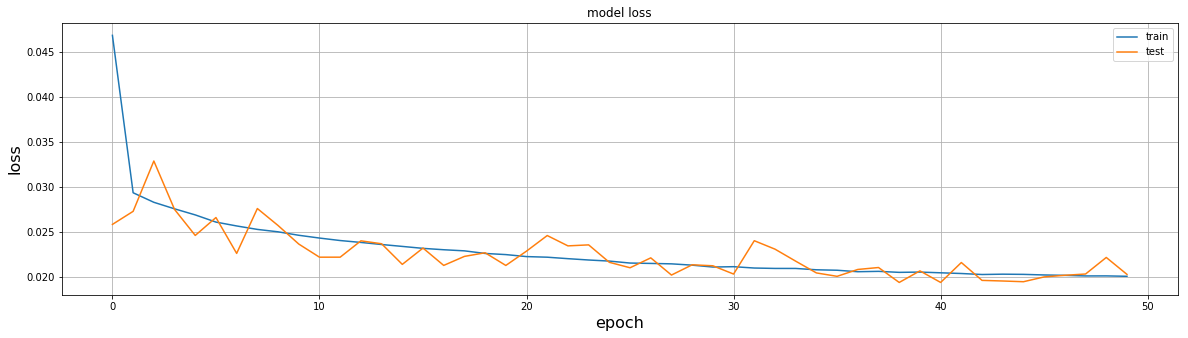

In [128]:
#print(history.history.keys())

plt.figure(figsize=(20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss', size=16)
plt.xlabel('epoch', size=16)
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

## Make prediction and visualize the prediction

In [129]:
# Restore trained model
loaded_model = load_model('./logs/stress')
loaded_model.load_weights('./logs/stress_weights.epoch.49.hdf5')
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 64)                512       
_________________________________________________________________
layer_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
layer_3 (Dense)              (None, 16)                528       
_________________________________________________________________
layer_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 9         
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


('RMS error : ', 764.34628079556092)


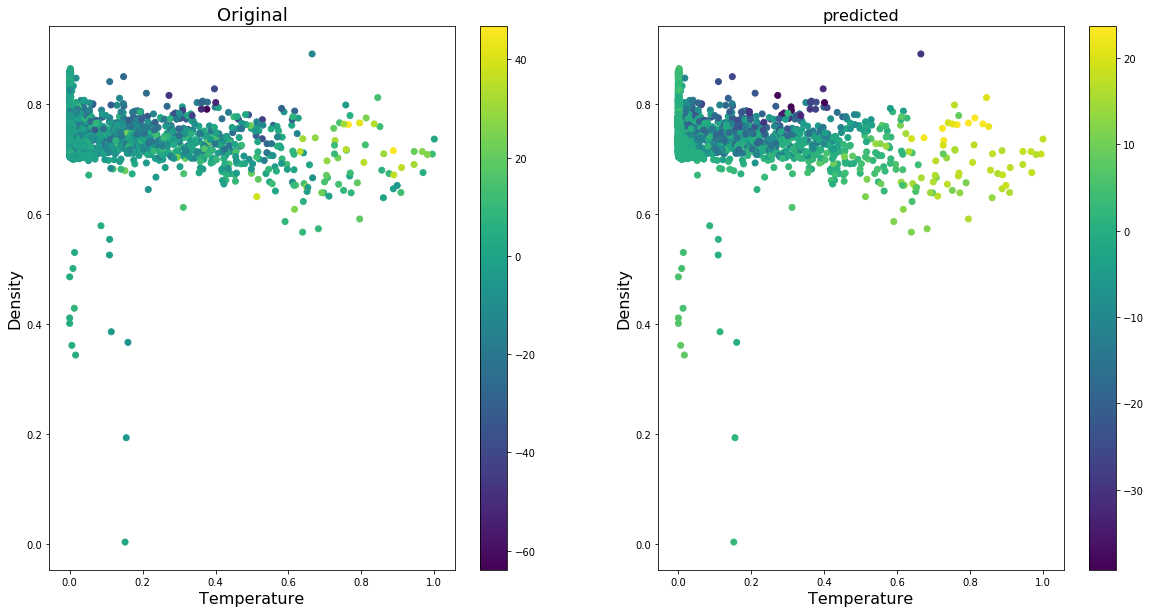

In [130]:
predicted = loaded_model.predict(X_test)

# transform to original unit
predicted = scaley.inverse_transform(predicted)
Y_test    = scaley.inverse_transform(Y_test)

# RMS error
error = np.sqrt(np.mean((predicted-Y_test)**2))
print("RMS error : ", error*100)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(X_test[:,0], X_test[:, 1], c=Y_test)
plt.title("Original", size=18)
plt.ylabel('Density', size=16)
plt.xlabel('Temperature', size=16)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:, 1], c=predicted)
plt.title("predicted", size=16)
plt.ylabel('Density', size=16)
plt.xlabel('Temperature', size=16)
plt.colorbar()

plt.show()

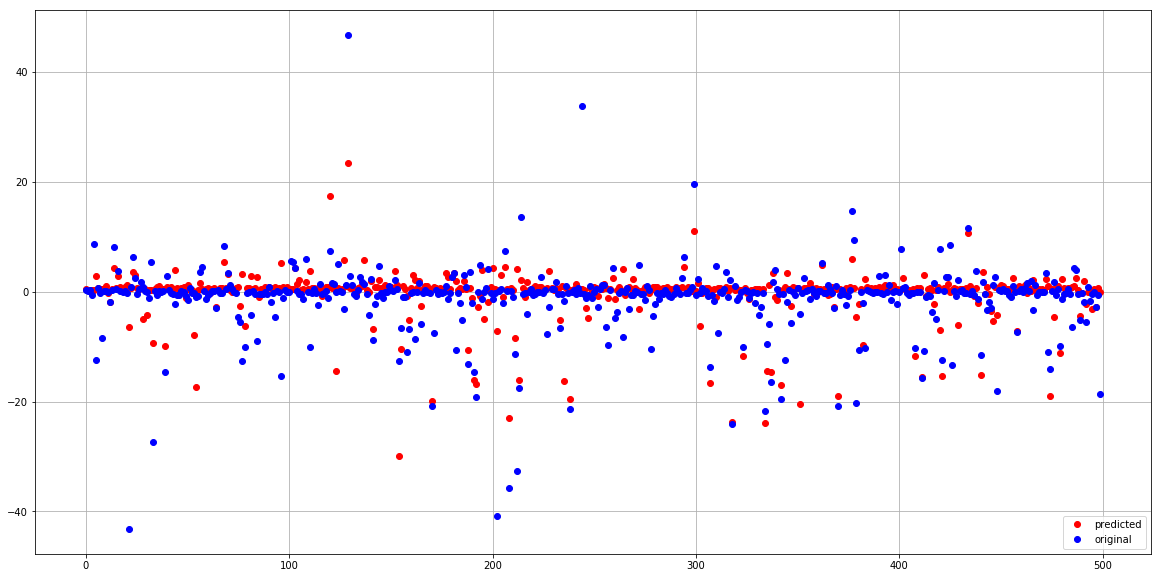

In [131]:
data = 500
plt.figure(figsize=(20,10))
plt.plot(predicted[:data], 'ro')
plt.plot(Y_test[:data], 'bo')
plt.legend(['predicted', 'original'], loc='lower right')
plt.grid()
plt.show()

## Restore model

In [68]:
# Evaluate with loaded model
evaluation = loaded_model.evaluate(X_test, Y_test, batch_size=10, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

7690/8000 [===========================>..] - ETA: 0s
Summary: Loss over the test dataset: 0.02, Accuracy: 0.00


## playinmg with the model

In [69]:
# "get_config()" returns a dictionary containing the configuration of the layer
# loaded_model.get_config()
# loaded_model.to_json()

#returns a list of all weight tensors in the model, as Numpy arrays
a = loaded_model.get_weights()
# print(a) # 10 layers
# print(a[2])

## Create image from weights

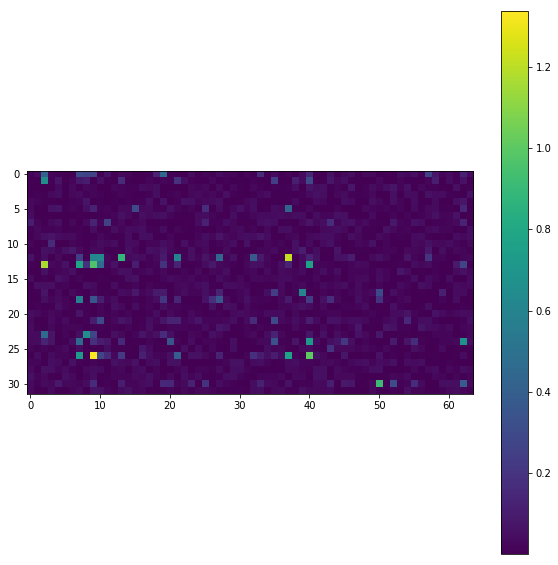

In [70]:
image = np.square(a[2].T)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap=plt.cm.viridis, interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
# from skimage import io, filters
# image = io.imread('download.jpg')
# # edges = filters.sobel(image)
# io.imshow(image)
# io.show()